In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Reading data in batches:
Batch number: 0
Returning bars 

Reading data in batches:
Batch number: 0
Returning bars 

Reading data in batches:
Batch number: 0
Returning bars 



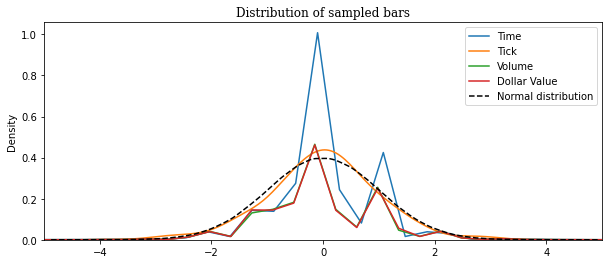

In [11]:
import datetime
from FinancialMachineLearning.barsampling.core import *

# 삼성 tick data 불러오기
df=pd.read_csv("./005930.txt", sep=",")

# date를 날짜로 바꿔주기
df['date']= pd.to_datetime(df['date'])

bar = StandardBarFeatures(file_path_or_df = df)

# tick bar 산출
tick = bar.tick_bar(threshold = 300)

# volume bar 산출
volume = bar.volume_bar(threshold = 40000)

# dollar bar 산출
dollar = bar.dollar_bar()

# 통계적 특성 확인
time_returns = np.log(df['close']).diff().dropna()
tick_returns = np.log(tick['close']).diff().dropna()
volume_returns = np.log(volume['close']).diff().dropna()
dollar_returns = np.log(dollar['close']).diff().dropna()

time_standard = (time_returns - time_returns.mean()) / time_returns.std()
tick_standard = (tick_returns - tick_returns.mean()) / tick_returns.std()
volume_standard = (volume_returns - volume_returns.mean()) / volume_returns.std()
dollar_standard = (dollar_returns - dollar_returns.mean()) / dollar_returns.std()

import seaborn as sns
fig, ax = plt.subplots(figsize = (10,4))

# kdeplot은 커널 밀도 추정(KDE: Kernel Density Estimator) =>히스토그램 같은 분포를 스무딩 시켜서 그려줌

sns.kdeplot(time_standard.values, label = "Time", ax = ax)  
sns.kdeplot(tick_standard.values, label = "Tick", ax = ax)
sns.kdeplot(volume_standard.values, label = "Volume", ax = ax)
sns.kdeplot(dollar_standard.values, label = "Dollar Value", ax = ax)
sns.kdeplot(np.random.normal(size=1000000), label = "Normal distribution", 
            color = 'black', linestyle = "--", ax = ax)

plt.legend()
plt.grid(False)
plt.xlim(-5, 5)
plt.title('Distribution of sampled bars', fontfamily = 'Serif', fontsize = 12)
plt.show()

# 결과적으로 tick bar가 통계적 특성이 normal에 제일 가까움을 알 수 있음

Reading data in batches:
Batch number: 0
Returning bars 



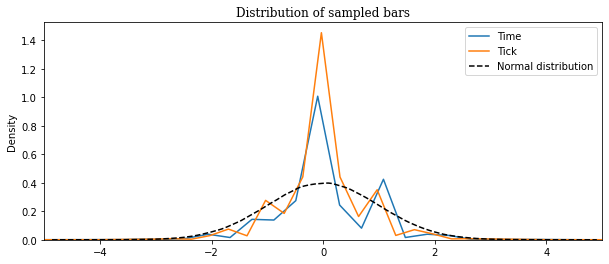

In [12]:
tick=bar.volume_bar(threshold = 50000)
tick_returns = np.log(tick['close']).diff().dropna()
tick_standard = (tick_returns - tick_returns.mean()) / tick_returns.std()


fig, ax = plt.subplots(figsize = (10,4))
sns.kdeplot(time_standard.values, label = "Time", ax = ax)  
sns.kdeplot(tick_standard.values, label = "Tick", ax = ax)
sns.kdeplot(np.random.normal(size=1000000), label = "Normal distribution", 
            color = 'black', linestyle = "--", ax = ax)

plt.legend()
plt.grid(False)
plt.xlim(-5, 5)
plt.title('Distribution of sampled bars', fontfamily = 'Serif', fontsize = 12)
plt.show()

In [35]:
# 볼린저밴드 전략 구현
from ta.volatility import BollingerBands
from ta.volume import money_flow_index, on_balance_volume
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price
from ta.momentum import tsi

bollinger_result=BollingerBands(close = tick["close"], window = 20, window_dev = 1.2)

tick['boll_hband']=np.array(bollinger_result.bollinger_hband_indicator()).astype(int)
tick['boll_lband']=np.array(bollinger_result.bollinger_lband_indicator())

label=[]

for indexs in tick.index:
    if tick.loc[indexs, 'boll_hband']==1:
        label.append(1)
    elif tick.loc[indexs, 'boll_lband']==1:
        label.append(-1)
    else:
        label.append(0)
        
tick['label']=label

# 기타 기술적 지표 계산

tick['mfi']=money_flow_index(high = tick.high, 
                           low = tick.low,
                           close = tick.close, 
                           volume = tick.volume,
                           window = 20)

tick['obv']=on_balance_volume(close=tick.close,
                           volume=tick.volume,
                           )

tick['rsi']=rsi(close=tick.close, window=20)

tick['vwap']=volume_weighted_average_price(high=tick.high,
                                        low=tick.low,
                                        close=tick.close,
                                        volume=tick.volume,
                                        window=20)
tick['tsi']=tsi(close=tick.close,
             window_fast=13,
             window_slow=25)

In [14]:
# meta labling
meta=[]
for data in tick.label:
    if data==1:
        meta.append(1)
    elif data==-1:
        meta.append(1)
    else:
        meta.append(0)
tick['meta']=meta

In [15]:
# 시장 미시구조 변수 산출
from FinancialMachineLearning.features.microstructure import *

corwin_schultz = CorwinSchultz(tick['high'], tick['low'])
spread = corwin_schultz.corwin_schultz_estimator(window = 20)

lambda_feature = BarbasedLambda(close = tick['close'],
                                volume = tick['volume'],
                                dollar_volume = tick.close * tick.volume)
kyle_lambda = lambda_feature.kyle()

In [16]:
tick['spread']=spread
tick['lambda']=kyle_lambda

In [17]:
data=tick[['date_time','close', 'volume']]
data.columns=['date_time','price','volume']
data.to_csv("./tick_bar.csv", index=False)

In [28]:
from FinancialMachineLearning.barsampling.bar_feature import BarFeature

def buy_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs > 0)).sum()

def sell_volume(df):
    tick_signs = tick_rule(df['price'])
    return (df['volume'] * (tick_signs < 0)).sum()
    
buy_volume_feature = BarFeature(name='buy_volume', function=buy_volume)
sell_volume_feature = BarFeature(name='sell_volume', function=sell_volume)
bars = vpin_volume_bars('./tick_bar.csv', additional_features = [buy_volume_feature, sell_volume_feature])

vpin_series = vpin(bars['volume'], bars['buy_volume'], window = 5)

Reading data in batches:
Batch number: 0
Returning bars 



In [29]:
tick['vpin']=vpin_series

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from sklearn.metrics import auc

tick=tick.dropna()

X=tick[['spread', 'lambda', 'mfi', 'obv', 'rsi', 'vwap', 'tsi', 'volume', 'vpin']]
y=tick['meta']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, shuffle=False)

tree = RandomForestClassifier(
        criterion='entropy', class_weight='balanced_subsample', min_weight_fraction_leaf=0.0, n_estimators=500, 
        max_features=1.0, oob_score=True, n_jobs=-1)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8271144805387319


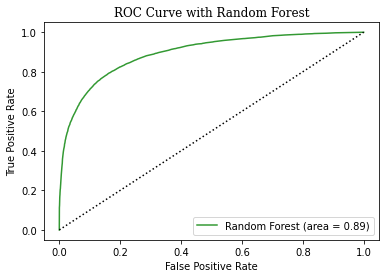

In [31]:
y_prob = tree.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Random Forest (area = {:.2f})'.format(roc_auc), color = 'green', alpha = 0.8)
plt.plot([0, 1], [0, 1], 'k:')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest', fontsize = 12, fontfamily = 'Serif')
plt.grid(False)
plt.legend()
plt.show()

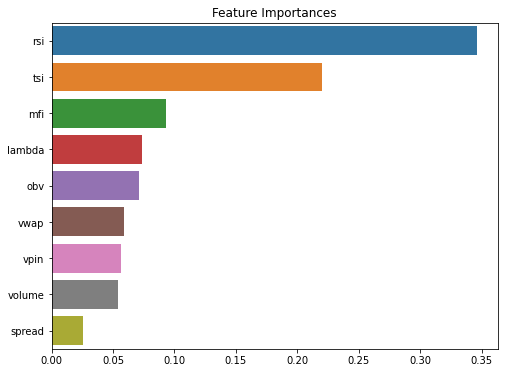

In [32]:
import seaborn as sns 
feature_name=X_train.columns
ser = pd.Series(tree.feature_importances_, index=feature_name)
ser=ser.sort_values(ascending=False)
plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ser, y=ser.index)
plt.show()

In [23]:
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     14739
           1       0.82      0.71      0.76      8879

    accuracy                           0.83     23618
   macro avg       0.83      0.81      0.82     23618
weighted avg       0.83      0.83      0.83     23618



In [24]:
from FinancialMachineLearning.feature_importance.importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    single_feature_importance,
    plot_feature_importance
)
from FinancialMachineLearning.feature_importance.orthogonal import get_orthogonal_features
from FinancialMachineLearning.machine_learning.cross_validation import PurgedKFold, ml_cross_val_score
from FinancialMachineLearning.multiprocess.multiprocess import process_jobs

In [25]:
def feature_importances(X, cont, method, allow_masking_effects=False, n_splits=10):
    clf = RandomForestClassifier(
        criterion='entropy', class_weight='balanced_subsample', min_weight_fraction_leaf=0.0, n_estimators=500, 
        max_features=1.0, oob_score=True, n_jobs=-1
    )

    fit = clf.fit(X, cont['meta'])
    oob_score = fit.oob_score_

    cv_gen = PurgedKFold(n_splits=n_splits, samples_info_sets=pd.Series(cont.index))
    oos_score = ml_cross_val_score(clf, X, cont['meta'], cv_gen=cv_gen, scoring=accuracy_score).mean()

    if method == 'MDI':
        imp = mean_decrease_impurity(fit, X.columns)
    elif method == 'MDA':
        imp = mean_decrease_accuracy(clf, X, cont['meta'], cv_gen, scoring=accuracy_score)
    elif method == 'SFI':
        imp = single_feature_importance(clf, X, cont['meta'], cv_gen, scoring=accuracy_score)
    
    return imp, oob_score, oos_score


def test_data_func(X, cont, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    feature_imp, oob_score, oos_score = feature_importances(X, cont, methods, allow_masking_effects)
    plot_feature_importance(
        feature_imp, oob_score=oob_score, oos_score=oos_score,
        save_fig = False
    )


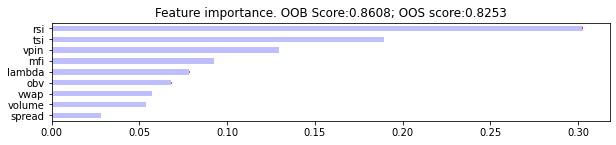

In [27]:
test_data_func(X, tick, methods='MDA')

In [36]:
# 백테스트 진행
import pandas_datareader as pdr
import datetime
from backtesting import Backtest, Strategy
from backtesting import Strategy

start=datetime.datetime(2008,1,1)
end=datetime.datetime(2012,12,31)
data=pdr.DataReader("005930", "naver", start, end).astype("float")

def bollinger_hband(df):
    bollinger_result=BollingerBands(close = pd.Series(df.Close), window = 20, window_dev = 1)
    boll_hband=np.array(bollinger_result.bollinger_hband_indicator()).astype(int)
    label=[]
    for data in boll_hband:
        if data==1:
            label.append(1)
        else:
            label.append(0)
    return label

def bollinger_lband(df):
    bollinger_result=BollingerBands(close = pd.Series(df.Close), window = 20, window_dev = 1)
    boll_lband=np.array(bollinger_result.bollinger_lband_indicator()).astype(int)
    label=[]
    for data in boll_lband:
        if data==1:
            label.append(-1)
        else:
            label.append(0)
    return label

def spread(high, low):
    corwin_schultz = CorwinSchultz(pd.Series(high), pd.Series(low))
    spread = corwin_schultz.corwin_schultz_estimator(window = 20)
    spread=spread.fillna(0)
    return spread

def lambda_data(close, volume):
    lambda_feature = BarbasedLambda(close = pd.Series(close),
                                    volume = pd.Series(volume),
                                    dollar_volume = tick.close * tick.volume)
    kyle_lambda = lambda_feature.kyle()
    kyle_lambda=kyle_lambda.fillna(0)
    return kyle_lambda

def model_predict(spread, kyle_lambda, mfi, obv, rsi_return, vwap, tsi_return, volume):
    data=pd.DataFrame({'spread': spread, 'kyle':kyle_lambda, 'mfi':mfi, 'obv' : obv, 'rsi':rsi_return, 'vwap':vwap, 'tsi':tsi_return, 'volume':volume})
    data=data.fillna(0)
    y_pred_tree = tree.predict(data)
    return y_pred_tree

def model_prob(spread, kyle_lambda, mfi, obv, rsi_return, vwap, tsi_return, volume):
    data=pd.DataFrame({'spread': spread, 'kyle':kyle_lambda, 'mfi':mfi, 'obv' : obv, 'rsi':rsi_return, 'vwap':vwap, 'tsi':tsi_return, 'volume':volume})
    data=data.fillna(0)
    y_pred_prob = tree.predict_proba(data)[:,1]
    return y_pred_prob

def mfi(data):
    return money_flow_index(high = pd.Series(data.High), 
                           low = pd.Series(data.Low),
                           close = pd.Series(data.Close), 
                           volume = pd.Series(data.Volume),
                           window = 20)

def obv(data):
    return on_balance_volume(close=pd.Series(data.Close),
                           volume=pd.Series(data.Volume))

def rsi_return(data):
    return rsi(close=pd.Series(data.Close), window=20)


def vwap(data):
    return volume_weighted_average_price(high=pd.Series(data.High),
                                        low=pd.Series(data.Low),
                                        close=pd.Series(data.Close),
                                        volume=pd.Series(data.Volume),
                                        window=20)

def tsi_return(data):
    return tsi(close=pd.Series(data.Close),
             window_fast=13,
             window_slow=25)
    
    
class my_strategy(Strategy):
    
    def init(self):
        self.bollinger_h = self.I(bollinger_hband, self.data)
        self.bollinger_l = self.I(bollinger_lband, self.data)
        self.bollinger=self.bollinger_h+self.bollinger_l
        self.spread=self.I(spread, self.data.High, self.data.Low)
        self.lambda_lst=self.I(lambda_data, self.data.Close, self.data.Volume)
        self.mfi=self.I(mfi, self.data)
        self.obv=self.I(obv, self.data)
        self.rsi=self.I(rsi_return, self.data)
        self.vwap=self.I(vwap, self.data)
        self.tsi=self.I(tsi_return, self.data)
        self.volume=self.data.Volume
        self.pred=self.I(model_predict, self.spread, self.lambda_lst, self.mfi, self.obv, self.rsi, self.vwap, self.tsi, self.volume)
        self.prob=self.I(model_prob, self.spread, self.lambda_lst, self.mfi, self.obv, self.rsi, self.vwap, self.tsi, self.volume)
        self.result=self.bollinger*self.pred
        
        
    def next(self):
        if self.result==1:
            self.buy( size=(self.prob[-1]) )

        elif self.result==-1:
            self.position.close( portion=(self.prob[-1]) )
            
bt = Backtest(data, my_strategy, cash=10000000, commission=.002)
stats = bt.run()
bt.plot()

Row(id='2016', ...)